## Time Series Feature Engineering Continued:
#### We're going to cover some new feature engineering ideas in today's lesson:
* Interpolation - aka up and downsampling - up sampling would be filling in hourly data if we only have daily data, downsampling would be to create weekly or monthly data from daily data!
(Interpolation also helps to overcome class imbalance)
* MinMaxScaler

**So lets pull the coingecko data back in from yesterday, convert it to json, extract the prices into a dataframe, and transform our datetime objects.**

In [2]:
import requests
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

dogecoin = requests.get('https://api.coingecko.com/api/v3/coins/dogecoin/market_chart?vs_currency=USD&days=365')
dg_json = dogecoin.json()

df = pd.DataFrame(dg_json['prices'], columns=['DateTime', 'Prices'])
df.head()

,DateTime,Prices
0,1537747200000,0.005950
1,1537833600000,0.005684
2,1537920000000,0.005748
3,1538006400000,0.005754
4,1538092800000,0.005889


#### Going to sort it by the datetime, and create a date time object:

In [3]:
df.sort_values(by='DateTime', inplace=True)

In [4]:
df.set_index(pd.to_datetime(df['DateTime'], unit='ms'), inplace=True)
df.drop(columns='DateTime', inplace=True)
df.head()

,Prices
DateTime,
2018-09-24,0.005950
2018-09-25,0.005684
2018-09-26,0.005748
2018-09-27,0.005754
2018-09-28,0.005889


### Interpolation - Upsampling, downsampling

* Interpolation is the process of filling in or removing values from time series data
* Do it using resample - change time-series data using resample() _(data aggregation)_ or asfreq _(data sampling)_
* Why would you want to upsample and downsample data?
    * To change the frequency of your data, to increase or decrease granularity
    * To overcome class imbalance

In [5]:
downsample_series = df['Prices'].resample('W')
downsample_series #here we've cut 6 days and made one row for the week

DatetimeIndexResampler [freq=<Week: weekday=6>, axis=0, closed=right, label=right, convention=start, base=0]

In [6]:
mean_df = downsample_series.max()
max_df = downsample_series.max()
min_df = downsample_series.min()
first_df = downsample_series.first() # takes the first of those seven days

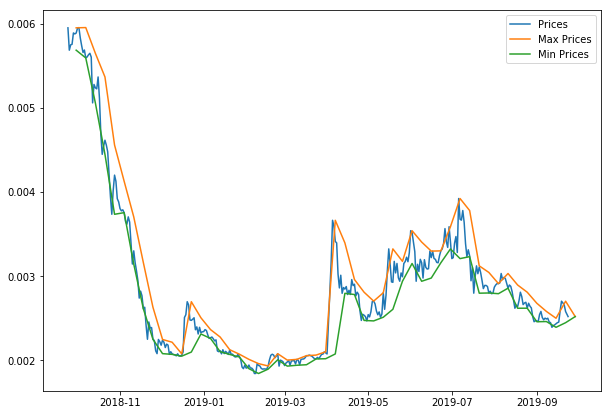

In [7]:
plt.figure(figsize=(10,7))

plt.plot(df.index, df['Prices']) # index is the date remember!
plt.plot(max_df.index, max_df)
plt.plot(min_df.index, min_df)
plt.legend(['Prices', 'Max Prices', 'Min Prices'])
plt.show()

In [8]:
upsample_series = df['Prices'].resample('H')
upsample_series

DatetimeIndexResampler [freq=<Hour>, axis=0, closed=left, label=left, convention=start, base=0]

In [9]:
linear_upsample = upsample_series.interpolate()
zero_upsample = upsample_series.interpolate(method='zero')
cubic_upsample = upsample_series.interpolate(method='cubic')


linear_upsample.head()

DateTime
2018-09-24 00:00:00    0.005950
2018-09-24 01:00:00    0.005939
2018-09-24 02:00:00    0.005928
2018-09-24 03:00:00    0.005916
2018-09-24 04:00:00    0.005905
Freq: H, Name: Prices, dtype: float64

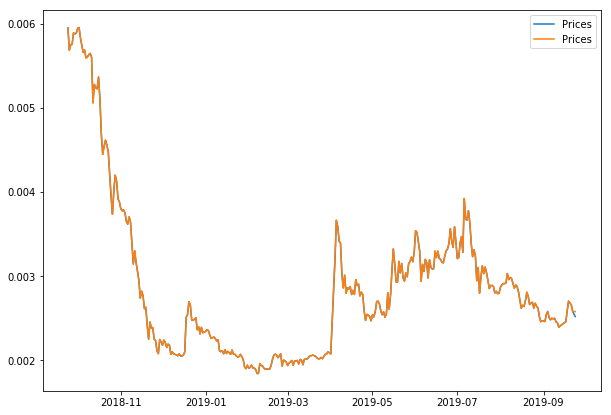

In [10]:
plt.figure(figsize=(10,7))
plt.plot(df.index, df['Prices']) # index is the date remember!
plt.plot(linear_upsample.index, linear_upsample)

plt.legend()
plt.show()

#These two lines are plotted on top of each other!

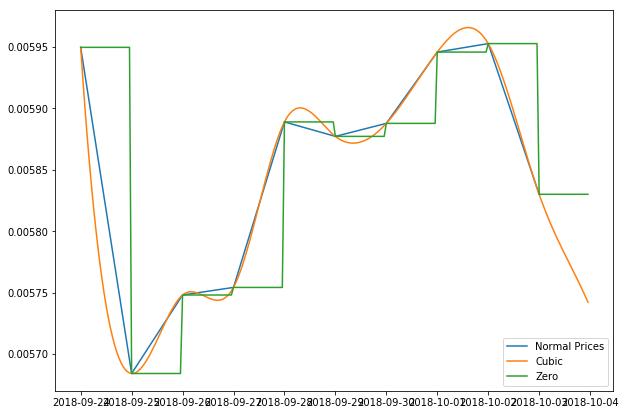

In [11]:
plt.figure(figsize=(10,7))
plt.plot(df.index[:10], df['Prices'][:10]) # This plots the original data

plt.plot(cubic_upsample.index[:240], cubic_upsample[:240])

plt.plot(zero_upsample.index[:240], zero_upsample[:240])

plt.legend(['Normal Prices','Cubic', 'Zero'])
plt.show()

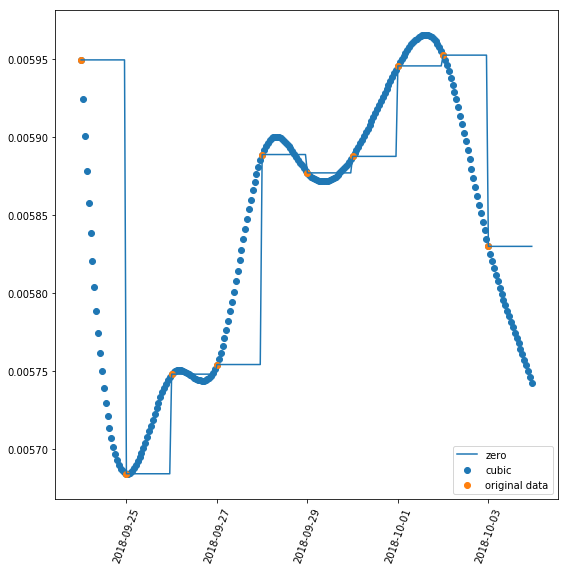

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(9,9))
plt.plot(zero_upsample.index[:240], zero_upsample[:240])
plt.scatter(cubic_upsample.index[:240], cubic_upsample[:240])#this plots upsampled data
plt.scatter(df.index[:10], df['Prices'][:10])#this plots the original data (normal == unsampled)#this plots upsampled data
plt.legend(['zero', 'cubic', 'original data'])
plt.xticks(rotation=70)
# plt.plot(max_df.index, max_df)
# plt.plot(min_df.index, min_df)
None

### Min / Max scaling
* Standardise/normalise the scale of the data being used on the training data
* Why do this? Do this because it normalises the scale of the features
* n.b Don't do min/max scaling on polynomial features

In [13]:
bitcoin = requests.get('https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=USD&days=365')

btc_json = bitcoin.json()

df2 = pd.DataFrame(btc_json['prices'], columns=['DateTime', 'Prices'])
df2.head()

,DateTime,Prices
0,1537747200000,6711.029452
1,1537833600000,6596.187313
2,1537920000000,6441.311545
3,1538006400000,6462.795635
4,1538092800000,6704.704246


In [14]:
df2.set_index(pd.to_datetime(df2['DateTime'], unit='ms'), inplace=True)
df2.drop(columns='DateTime', inplace=True)

In [15]:
df2.head()

,Prices
DateTime,
2018-09-24,6711.029452
2018-09-25,6596.187313
2018-09-26,6441.311545
2018-09-27,6462.795635
2018-09-28,6704.704246


**So lets pull in data which is scaled differently from dogecoin, e.g. bitcoin, and visualise the two together**

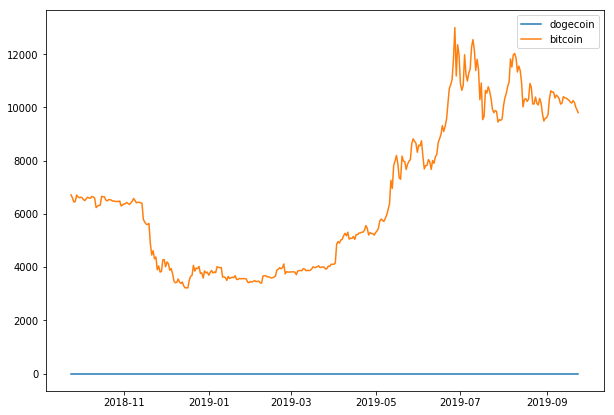

In [16]:
plt.figure(figsize=(10,7))
plt.plot(df.index, df['Prices'])
plt.plot(df2.index, df2['Prices'])
plt.legend(['dogecoin', 'bitcoin'])

**Not very useful! Lets scale the data using MinMaxScaler.fit_transform( )**

In [17]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [18]:
m = MinMaxScaler()

x_array = np.array(df['Prices']).reshape(-1,1)

XMin_max_dc = m.fit_transform(x_array)

print(XMin_max_dc[:5])

print(f'Range of scaled dogecoin is: {XMin_max_dc.min()} to {XMin_max_dc.max()}') 
# We now have a scale of 0 to 1!

[[0.99925756]
 [0.93462908]
 [0.9501836 ]
 [0.95168703]
 [0.98447929]]
Range of scaled dogecoin is: 0.0 to 1.0


In [19]:
x_array = np.array(df2['Prices']).reshape(-1,1)

XMin_max_btc = m.fit_transform(x_array)

print(XMin_max_btc[:5])

print(f'Range of scaled bitcoin is: {XMin_max_btc.min()} to {XMin_max_btc.max()}')

[[0.35731922]
 [0.34557607]
 [0.32973928]
 [0.33193613]
 [0.35667244]]
Range of scaled bitcoin is: 0.0 to 1.0


#### Now we can plot the scaled results!

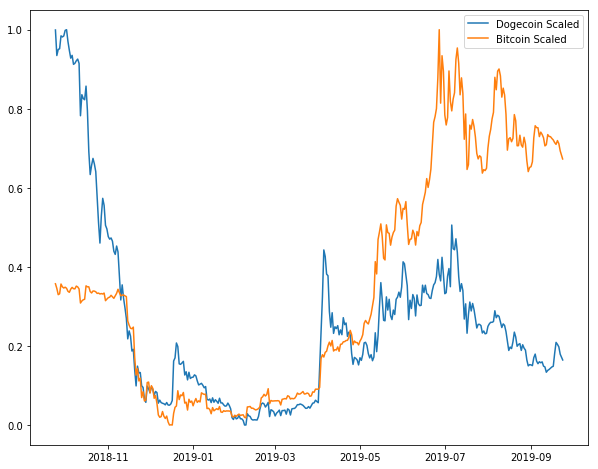

In [20]:
plt.figure(figsize=(10,8))
plt.plot(df.index, XMin_max_dc)
plt.plot(df2.index, XMin_max_btc)
plt.legend(['Dogecoin Scaled', 'Bitcoin Scaled'])
plt.show()